In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d basilb2s/language-detection

Dataset URL: https://www.kaggle.com/datasets/basilb2s/language-detection
License(s): CC0-1.0
  0% 0.00/542k [00:00<?, ?B/s]
100% 542k/542k [00:00<00:00, 531MB/s]


In [ ]:
!unzip language-detection.zip

Archive:  language-detection.zip
  inflating: Language Detection.csv  


In [ ]:
import os
import random
from tokenizers import Tokenizer, models, trainers, normalizers, pre_tokenizers
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.implementations import ByteLevelBPETokenizer
from collections import defaultdict
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers
from tokenizers.processors import BertProcessing
from tokenizers.normalizers import NFD, StripAccents, Lowercase, Sequence
from tokenizers.pre_tokenizers import Whitespace
from collections import defaultdict
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
df = pd.read_csv("Language Detection.csv")
df.columns = ['Text', 'Language']
df.sample(10)

,Text,Language
7222,Le decisioni da prendere sul contenuto e sulle...,Italian
859,[42] Reinforcement learning is an area of mach...,English
7540,"stava cercando di aiutarti, ma non è riuscito ...",Italian
9487,إلى والدتي ، دعني أذهب إلى المنزل ميليسا ونظر ...,Arabic
7322,"Nel punteggio complessivo, Wikipedia ha ottenu...",Italian
3324,"Avec l’âge classique au XVIIe siècle, et la na...",French
10288,ನಾರ್ಸಿಸಾ ಈ ಬೀಜಗಳನ್ನು ನೆಡಲು ನೀವು ನನಗೆ ಸಹಾಯ ಮಾಡು...,Kannada
2148,இந்த வீடியோவில் நான் தினசரி பயன்பாட்டிற்காகவும...,Tamil
739,"[353] In 2015, French researchers José Lages o...",English
9428,ذلك سيكون رائعا، شكرا.,Arabic


In [147]:
df.shape


(10337, 2)

In [148]:
df.Language.value_counts()

,count
Language,
English,1385
French,1014
Spanish,819
Portugeese,739
Italian,698
Russian,692
Sweedish,676
Malayalam,594
Dutch,546


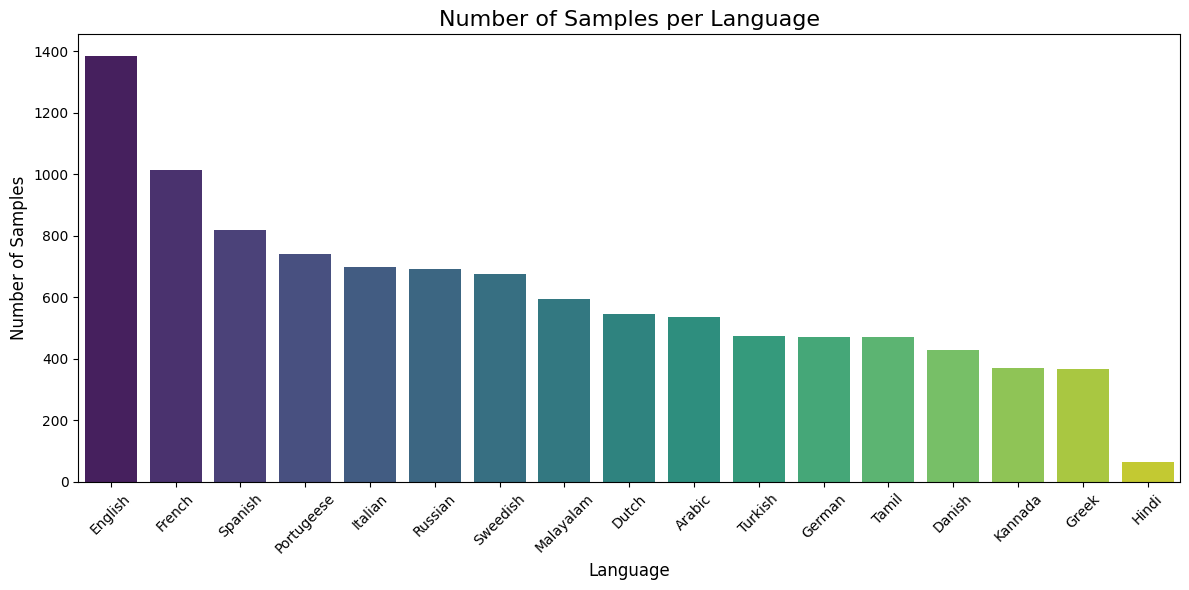

In [142]:
lang_counts = df['Language'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=lang_counts.index, y=lang_counts.values, palette="viridis")
plt.title("Number of Samples per Language", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Train size: 9303
Test size: 1034
Language
English       0.133935
French        0.098140
Spanish       0.079222
Portugeese    0.071482
Italian       0.067505
Name: proportion, dtype: float64
Language
English       0.134429
French        0.097679
Spanish       0.079304
Portugeese    0.071567
Italian       0.067698
Name: proportion, dtype: float64


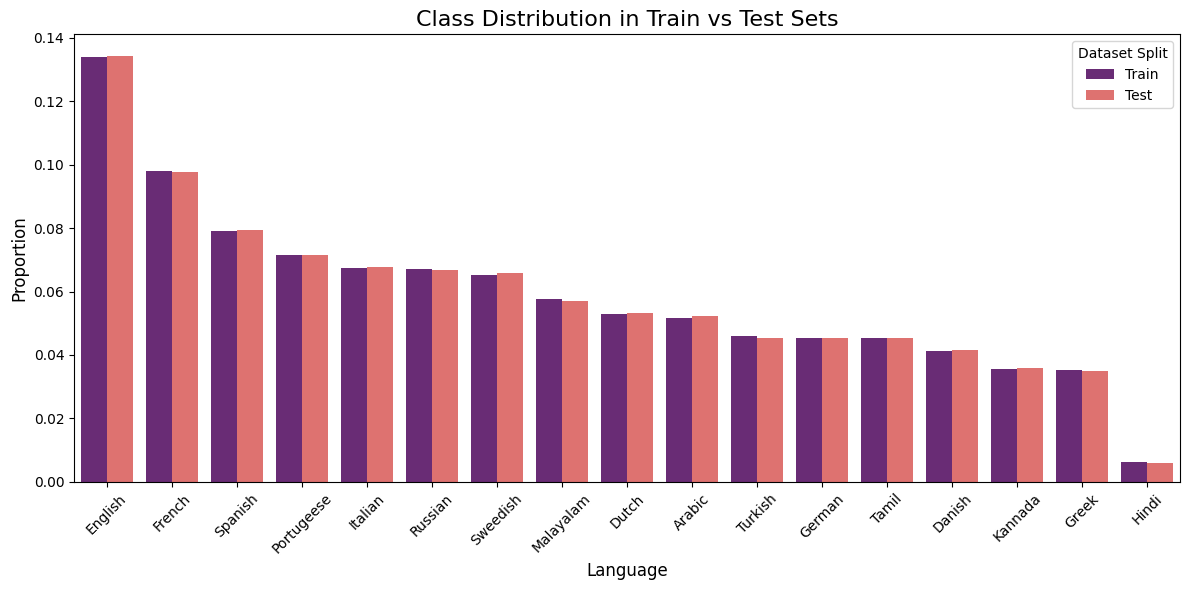

In [146]:
# Stratified split to maintain class distribution
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['Language'], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

print(train_df['Language'].value_counts(normalize=True).head())
print(test_df['Language'].value_counts(normalize=True).head())


train_dist = train_df['Language'].value_counts(normalize=True)
test_dist = test_df['Language'].value_counts(normalize=True)

distribution_df = pd.DataFrame({
    'Language': train_dist.index,
    'Train': train_dist.values,
    'Test': test_dist.reindex(train_dist.index).values  # ensure same order
})

distribution_df = distribution_df.melt(id_vars='Language', var_name='Split', value_name='Proportion')

plt.figure(figsize=(12, 6))
sns.barplot(data=distribution_df, x='Language', y='Proportion', hue='Split', palette='magma')
plt.title("Class Distribution in Train vs Test Sets", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Dataset Split')
plt.tight_layout()
plt.show()


In [ ]:
alphabets = {
    "English": "abcdefghijklmnopqrstuvwxyz",
    "Malayalam": "അആഇഈഉഊഋഎഏഐഒഓഔകഖഗഘങചഛജഝഞടഠഡഢണതഥദധനപഫബഭമയരറലളഴവശഷസഹ",
    "Hindi": "अआइईउऊएऐओऔकखगघङचछजझञटठडढणतथदधनपफबभमयरलवशषसह",
    "Tamil": "அஆஇஈஉஊஎஏஐஒஓஔகஙசஞடணதநபமயரலவழளறன",
    "Kannada": "ಅಆಇಈಉಊಎಏಐಒಓಔಕಖಗಘಙಚಛಜಝಞಟಠಡಢಣತಥದಧನಪಫಬಭಮಯರಲವಶಷಸಹ",
    "French": "abcdefghijklmnopqrstuvwxyzçéèêëàâäîïôöùûüÿ",
    "Spanish": "abcdefghijklmnopqrstuvwxyzáéíóúüñ",
    "Portuguese": "abcdefghijklmnopqrstuvwxyzáâãàçéêíóôõúü",
    "Italian": "abcdefghijklmnopqrstuvwxyzàèéìíîòóùú",
    "Russian": "абвгдеёжзийклмнопрстуфхцчшщъыьэюя",
    "Sweedish": "abcdefghijklmnopqrstuvwxyzåäö",
    "Dutch": "abcdefghijklmnopqrstuvwxyz",
    "Arabic": "ابتثجحخدذرزسشصضطظعغفقكلمنهويءآأؤإئىة",
    "Turkish": "abcçdefgğhıijklmnoöprsştuüvyz",
    "German": "abcdefghijklmnopqrstuvwxyzäöüß",
    "Danish": "abcdefghijklmnopqrstuvwxyzæøå",
    "Greek": "αβγδεζηθικλμνξοπρσςτυφχψω"
}

In [155]:
train_text_data = train_df['Text'].astype(str).tolist()
test_text_data = test_df['Text'].astype(str).tolist()

all_chars = set("".join(train_text_data))

In [156]:
for chars in alphabets.values():
    all_chars.update(list(chars))

In [157]:
all_chars

{'\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 '\\',
 ']',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '|',
 '}',
 '\xa0',
 '£',
 '«',
 '°',
 '·',
 'º',
 '»',
 '¿',
 'À',
 'Á',
 'Â',
 'Ä',
 'Å',
 'Ç',
 'È',
 'É',
 'Ñ',
 'Ö',
 '×',
 'Ü',
 'ß',
 'à',
 'á',
 'â',
 'ã',
 'ä',
 'å',
 'æ',
 'ç',
 'è',
 'é',
 'ê',
 'ë',
 'ì',
 'í',
 'î',
 'ï',
 'ñ',
 'ò',
 'ó',
 'ô',
 'õ',
 'ö',
 'ø',
 'ù',
 'ú',
 'û',
 'ü',
 'ÿ',
 'ć',
 'ğ',
 'İ',
 'ı',
 'ń',
 'ō',
 'œ',
 'Ş',
 'ş',
 'ə',
 'ɛ',
 'ɨ',
 'ɪ',
 'ˈ',
 'ˌ',
 'ː',
 '́',
 'Ά',
 'Έ',
 'Ί',
 'Α',
 'Β',
 'Γ',
 'Δ',
 'Ε',
 'Η',

In [158]:

lang_to_texts = defaultdict(list)
for text, lang in zip(train_df["Text"], train_df["Language"]):
    lang_to_texts[lang].append(str(text))

vocab_per_lang = 300  # desired merges per language
special_tokens = ["[PAD]", "[UNK]"]

lang_vocab = {}
lang_merges = {}

# train tokenizer per language
for lang, texts in lang_to_texts.items():
    print(f"Training BPE for {lang} with {len(texts)} samples")

    lang_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
    lang_tokenizer.normalizer = normalizers.Sequence([normalizers.NFC(), normalizers.Lowercase()])
    lang_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

    trainer = BpeTrainer(vocab_size=vocab_per_lang, show_progress=False, special_tokens=special_tokens)
    lang_tokenizer.train_from_iterator(texts, trainer=trainer)

    lang_tokenizer.save(f"{lang}_tokenizer.json")
    with open(f"{lang}_tokenizer.json", "r", encoding="utf-8") as f:
        tok_json = json.load(f)
        lang_vocab[lang] = list(tok_json["model"]["vocab"].items())
        lang_merges[lang] = tok_json["model"]["merges"]

# Merge tokenizers
combined_vocab = {}
combined_merges = []

next_id = 0
id_map = {}

for token in special_tokens:
    if token not in combined_vocab:
        combined_vocab[token] = next_id
        id_map[token] = next_id
        next_id += 1

for lang in lang_vocab:
    top_vocab = lang_vocab[lang]
    for token, _ in top_vocab:
        if token not in combined_vocab:
            combined_vocab[token] = next_id
            id_map[token] = next_id
            next_id += 1
    for merge in lang_merges[lang]:
        if merge not in combined_merges:
            combined_merges.append(merge)

tokenizer = Tokenizer(BPE(vocab=combined_vocab, merges=[tuple(pair) for pair in combined_merges], unk_token="[UNK]"))
tokenizer.normalizer = normalizers.Sequence([normalizers.NFC(), normalizers.Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

tokenizer.save("balanced_multilingual_bpe.json")

enc = tokenizer.encode("Hello! क्या हाल है؟ ça va bien?")
print(enc.tokens)


Training BPE for Italian with 628 samples
Training BPE for Arabic with 482 samples
Training BPE for Spanish with 737 samples
Training BPE for French with 913 samples
Training BPE for Greek with 329 samples
Training BPE for Malayalam with 535 samples
Training BPE for Russian with 623 samples
Training BPE for English with 1246 samples
Training BPE for Kannada with 332 samples
Training BPE for Sweedish with 608 samples
Training BPE for Danish with 385 samples
Training BPE for Portugeese with 665 samples
Training BPE for Dutch with 491 samples
Training BPE for Tamil with 422 samples
Training BPE for Hindi with 57 samples
Training BPE for German with 423 samples
Training BPE for Turkish with 427 samples
['hel', 'lo', '!', 'क्या', 'हा', 'ल', 'है', '؟', 'ça', 'va', 'bi', 'en', '?']


In [159]:
print(f"Combined tokenizer vocab size: {tokenizer.get_vocab_size()}")

shared_size = train_df['Language'].value_counts().shape[0] * vocab_per_lang - tokenizer.get_vocab_size()
print(f"Number of shared tokens (tokens exising in more than one lang): {shared_size}")

Combined tokenizer vocab size: 3102
Number of shared tokens (tokens exising in more than one lang): 1998


In [160]:
enc = tokenizer.encode("لقد أخفقت في الأمر إذا كنت تريد أن يعمل شخص ما...")
print(enc.tokens)


['لقد', 'أ', 'خ', 'ف', 'ق', 'ت', 'في', 'الأ', 'مر', 'إذا', 'كنت', 'ت', 'ريد', 'أن', 'يع', 'مل', 'شخص', 'ما', '.', '.', '.']


In [162]:
def tokenize(text):
    return tokenizer.encode(text).ids

train_tokenized_data = [tokenize(text) for text in train_text_data]
test_tokenized_data = [tokenize(text) for text in test_text_data]

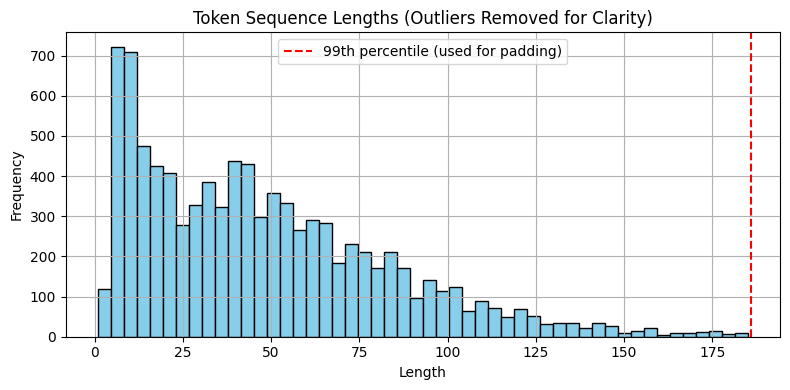

In [163]:
lengths = [len(x) for x in train_tokenized_data]

# For plotting only, remove top 1% extreme outliers
cutoff_plot = int(np.percentile(lengths, 99))
lengths_for_plot = [l for l in lengths if l <= cutoff_plot]

plt.figure(figsize=(8, 4))
plt.hist(lengths_for_plot, bins=50, color="skyblue", edgecolor="black")
plt.axvline(np.percentile(lengths, 99), color='red', linestyle='--', label='99th percentile (used for padding)')
plt.title("Token Sequence Lengths (Outliers Removed for Clarity)")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [165]:
# Use 90th percentile as max length, Pad or truncate sequences
cutoff_len = int(np.percentile(lengths, 99))
X_train = np.array([
    x[:cutoff_len] + [0] * max(0, cutoff_len - len(x))
    for x in train_tokenized_data
])
X_test = np.array([
    x[:cutoff_len] + [0] * max(0, cutoff_len - len(x))
    for x in test_tokenized_data
])


In [168]:
X_train.shape

(9303, 185)

In [169]:
X_test.shape

(1034, 185)

In [170]:
# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(train_df['Language'])
y_test = le.transform(test_df['Language'])

In [172]:
# Step 1: Convert token IDs to subword strings
id_to_token = {v: k for k, v in tokenizer.get_vocab().items()}

# Remove padding (0) before decoding
train_decoded_texts = []
test_decoded_texts = []
for ids in X_train:
    tokens = [id_to_token[i] for i in ids if i != 0]
    train_decoded_texts.append(" ".join(tokens))

for ids in X_test:
    tokens = [id_to_token[i] for i in ids if i != 0]
    test_decoded_texts.append(" ".join(tokens))

# Step 2: Apply TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(train_decoded_texts)  # Sparse matrix
X_test_tfidf = vectorizer.transform(test_decoded_texts)  # Sparse matrix

print(f"Train TF-IDF matrix shape: {X_train_tfidf.shape}")
print(f"Test TF-IDF matrix shape: {X_test_tfidf.shape}")


Train TF-IDF matrix shape: (9303, 1654)
Test TF-IDF matrix shape: (1034, 1654)


In [173]:
# ---------------------------
# Train-Test Split and NB Training
# ---------------------------
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)




MultinomialNB()

In [180]:
# ---------------------------
# Evaluation
# ---------------------------
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00        54
      Danish       0.97      0.88      0.93        43
       Dutch       0.98      0.96      0.97        55
     English       0.83      1.00      0.91       139
      French       0.96      0.98      0.97       101
      German       1.00      0.96      0.98        47
       Greek       1.00      1.00      1.00        36
       Hindi       1.00      1.00      1.00         6
     Italian       0.97      0.93      0.95        70
     Kannada       1.00      0.86      0.93        37
   Malayalam       1.00      0.86      0.93        59
  Portugeese       0.99      0.97      0.98        74
     Russian       1.00      0.97      0.99        69
     Spanish       0.99      0.99      0.99        82
    Sweedish       1.00      0.99      0.99        68
       Tamil       1.00      0.96      0.98        47
     Turkish       0.98      0.94      0.96        47

    accuracy              

In [183]:
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore')


In [182]:
styled_report = report_df.style.background_gradient(cmap="Blues").format("{:.2f}")
styled_report

,precision,recall,f1-score,support
Arabic,1.00,1.00,1.00,54.00
Danish,0.97,0.88,0.93,43.00
Dutch,0.98,0.96,0.97,55.00
English,0.83,1.00,0.91,139.00
French,0.96,0.98,0.97,101.00
German,1.00,0.96,0.98,47.00
Greek,1.00,1.00,1.00,36.00
Hindi,1.00,1.00,1.00,6.00
Italian,0.97,0.93,0.95,70.00
Kannada,1.00,0.86,0.93,37.00


In [184]:
def predict_language(text, tokenizer, vectorizer, model, le):
    token_ids = tokenizer.encode(text).ids
    id_to_token = {v: k for k, v in tokenizer.get_vocab().items()}
    tokens = [id_to_token[i] for i in token_ids if i in id_to_token]
    token_str = " ".join(tokens)
    X_input = vectorizer.transform([token_str])
    y_pred = model.predict(X_input)
    predicted_label = le.inverse_transform([y_pred[0]])[0]
    return predicted_label


In [185]:
sentence = "¡Hola! ¿Cómo estás?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Spanish


In [186]:
sentence = "നമസ്കാരം, നിങ്ങൾ എങ്ങനെയിരിക്കുന്നു?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Malayalam


In [187]:
sentence = "नमस्ते, आप कैसे हैं?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Hindi


In [188]:
sentence = "Olá, como você está?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Portugeese


In [189]:
sentence = "Hallo, hoe gaat het met je?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Dutch


In [190]:
sentence = "Hola, ¿cómo estás?"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Spanish


In [141]:
sentence = "Γειά σου, πώς είσαι;"
predicted_lang = predict_language(sentence, tokenizer, vectorizer, model, le)
print("Predicted Language:", predicted_lang)


Predicted Language: Greek
